In [28]:
#pip install transformers PyPDF2 python-docx matplotlib scikit-learn seaborn torch numpy

In [1]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel
from tqdm.auto import tqdm
import warnings
import json
import csv
warnings.filterwarnings('ignore')

# Paths
BASE_DIR = Path.cwd().parent.parent.parent
DATA_DIR = BASE_DIR / "oc_mini"

# Add dcat package to path
sys.path.insert(0, str(BASE_DIR / "cat"/"dcat"))

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#device = torch.device("mps")
print(f"Using device: {device}")


Using device: cuda


In [2]:
from notebook_utils import load_cluster_and_metadata

# Load tree and metadata
tree_path = DATA_DIR / "clustering" / "disjoint" / "oc_mini_clusters_0.001.csv"
metadata_path = DATA_DIR / "metadata" / "oc_mini_node_metadata.csv"

cluster_df, metadata_df = load_cluster_and_metadata(tree_path, metadata_path)

print(f"\nFirst few rows of cluster data:")
print(cluster_df.head(10))

print(f"\nFirst few rows of metadata:")
print(metadata_df.head())


Loading cluster data from /home/rkv4/oc_mini/clustering/disjoint/oc_mini_clusters_0.001.csv...
  ✓ Loaded: 19705 node-cluster assignments

Loading metadata from /home/rkv4/oc_mini/metadata/oc_mini_node_metadata.csv...
  ✓ Loaded: 14442 entries

Cluster Statistics:
  Unique nodes: 19705
  Unique clusters: 5
  Mean cluster size: 3941.00
  Median cluster size: 2480
  Largest cluster: 8989 nodes

First few rows of cluster data:
      node  cluster
0    45066        5
1   989648        0
2  1146632        0
3  3732252        0
4  9488729        5
5  9489474        5
6  9489060        5
7  6382148        5
8  6382959        5
9  1623959        5

First few rows of metadata:
     id                        doi  \
0   128  10.1101/2021.05.10.443415   
1   163  10.1101/2021.05.07.443114   
2   200  10.1101/2021.05.11.443555   
3   941       10.3390/ijms20020449   
4  1141       10.3390/ijms20040865   

                                               title  \
0  Improved protein contact prediction

In [3]:
# Reload modules to pick up changes
import importlib
import split_utils
importlib.reload(split_utils)
from split_utils import create_node_based_split, print_split_info

In [4]:
from split_utils import create_node_based_split, print_split_info

# Create train/test split at NODE level WITHIN each cluster
# This ensures all clusters have both train and test nodes
# Test nodes can be used to evaluate cluster membership prediction
train_node_ids, test_node_ids = create_node_based_split(
    cluster_df, 
    metadata_df,
    test_ratio=0.1,  # 10% of nodes from each cluster for testing
    seed=42
)

# Print detailed split information
print_split_info(train_node_ids, test_node_ids, cluster_df)

Creating node-based split from 5 clusters...
  Cluster 5: 2922 nodes -> 2630 train, 292 test
  Cluster 0: 7058 nodes -> 6353 train, 705 test
  Cluster 40: 1447 nodes -> 1303 train, 144 test
  Cluster 58: 1728 nodes -> 1556 train, 172 test
  Cluster 30: 1287 nodes -> 1159 train, 128 test

Node-based Split Summary:
  Train nodes: 13001 (from all clusters)
  Test nodes: 1441 (from all clusters)
  Total: 14442 nodes

TRAIN/TEST SPLIT SUMMARY

TRAIN SET:
  Nodes: 13001
  Clusters represented: 5
  Avg nodes per cluster: 2600.20
  Median nodes per cluster: 1556
  Range: [1159, 6353]

TEST SET:
  Nodes: 1441
  Clusters represented: 5
  Avg nodes per cluster: 288.20
  Median nodes per cluster: 172
  Range: [128, 705]

CLUSTER DISTRIBUTION:
  Cluster 0: 7058 total -> 6353 train (90.0%), 705 test (10.0%)
  Cluster 5: 2922 total -> 2630 train (90.0%), 292 test (10.0%)
  Cluster 30: 1287 total -> 1159 train (90.1%), 128 test (9.9%)
  Cluster 40: 1447 total -> 1303 train (90.0%), 144 test (10.0%)
  


DISJOINT CLUSTER TRIPLET LOSS TRAINING

Loading allenai/scibert_scivocab_uncased...

Creating training dataset...
Generating triplets from 5 clusters...
Total nodes: 13001


Generating triplets: 100%|██████████| 5/5 [00:00<00:00, 243.01it/s]


Generated 25 triplets
  Generated 25 training triplets
  Train samples: 22
  Val samples: 3

Triplet Margin Loss:
  Margin: 0.5

Training for 3 epochs...

Epoch 1/3


Training: 100%|██████████| 2/2 [00:01<00:00,  1.52it/s, loss=0.2904]


Train loss: 0.3357


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 13.43it/s]


Val loss: 0.3804
✓ New best validation loss!

Epoch 2/3


Training: 100%|██████████| 2/2 [00:01<00:00,  1.55it/s, loss=0.1251]


Train loss: 0.1716


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 13.80it/s]


Val loss: 0.2733
✓ New best validation loss!

Epoch 3/3


Training: 100%|██████████| 2/2 [00:01<00:00,  1.55it/s, loss=0.0445]


Train loss: 0.0562


Evaluating: 100%|██████████| 1/1 [00:00<00:00, 13.84it/s]


Val loss: 0.1641
✓ New best validation loss!

Training complete! Best val loss: 0.1641


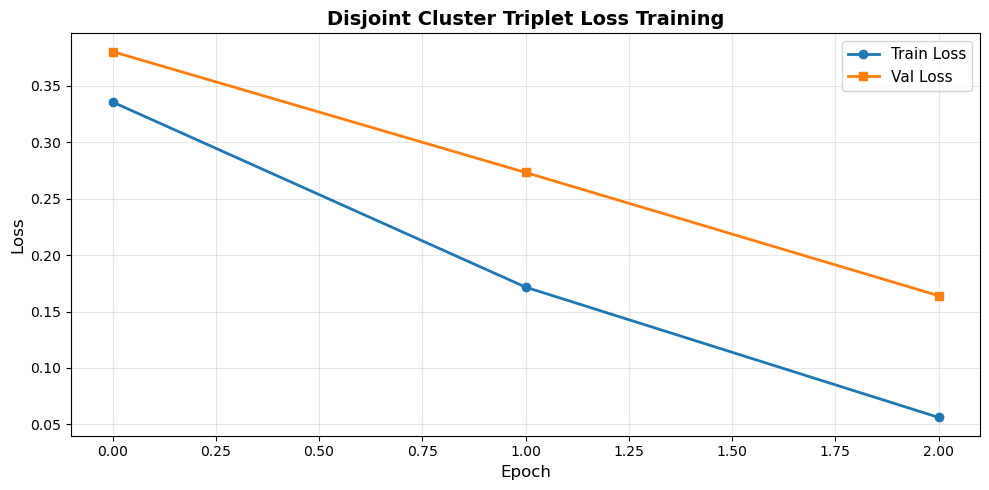

In [17]:
from notebook_utils import train_disjoint_model, plot_training_history

# Training hyperparameters
MODEL_NAME = 'allenai/scibert_scivocab_uncased'  # Changed to match hcat experiments
BATCH_SIZE = 16
EPOCHS = 3
LEARNING_RATE = 2e-5
MARGIN = 0.5  # Changed to match hcat experiments
SAMPLES_PER_CLUSTER = 5  # Changed to match hcat experiments

# Train the model using ONLY train nodes
model, tokenizer, history = train_disjoint_model(
    cluster_df=cluster_df,
    metadata_df=metadata_df,
    train_node_ids=train_node_ids,  # Train on these nodes only
    model_name=MODEL_NAME,
    device=device,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    lr=LEARNING_RATE,
    margin=MARGIN,
    samples_per_cluster=SAMPLES_PER_CLUSTER,
    pooling='cls'
)

# Plot training history
plot_training_history(history)

In [18]:
from notebook_utils import compute_finetuned_embeddings

# Compute embeddings for ALL nodes using FINE-TUNED model
# But we will evaluate only on test nodes
print("Computing embeddings with fine-tuned model...")
embeddings_dict = compute_finetuned_embeddings(
    model=model,
    tokenizer=tokenizer,
    metadata_df=metadata_df,
    device=device,
    batch_size=32
)

print(f"\nTotal embeddings computed: {len(embeddings_dict)}")
print(f"Test nodes with embeddings: {len([n for n in test_node_ids if n in embeddings_dict])}")


# from notebook_utils import compute_embeddings

# # Compute embeddings for ALL nodes (both train and test)
# # But we will evaluate only on test nodes
# print("Computing embeddings for all nodes...")
# embeddings_dict = compute_embeddings(
#     model=model,
#     tokenizer=tokenizer,
#     metadata_df=metadata_df,
#     device=device,
#     batch_size=32
# )

# print(f"\nTotal embeddings computed: {len(embeddings_dict)}")
# print(f"Test nodes with embeddings: {len([n for n in test_node_ids if n in embeddings_dict])}")

Computing embeddings with fine-tuned model...
Preparing 14442 documents...


Preparing:   0%|          | 0/14442 [00:00<?, ?it/s]

Computing embeddings:   0%|          | 0/452 [00:00<?, ?it/s]

✓ Computed embeddings for 14442 nodes

Total embeddings computed: 14442
Test nodes with embeddings: 1441


# Evaluation on Test Set

Now we evaluate the model performance on the **held-out test nodes**. These nodes were excluded during training, so we can test if the model learned to predict their cluster membership!

In [19]:
from evaluation import evaluate_cluster_quality

# Evaluate how well embeddings preserve cluster structure on TEST set
cluster_quality_results = evaluate_cluster_quality(
    embeddings_dict=embeddings_dict,
    cluster_df=cluster_df,
    test_node_ids=test_node_ids  # Only evaluate on test nodes
)


CLUSTER QUALITY EVALUATION

Evaluating 1441 nodes from 5 clusters...

Results:
  Silhouette Score: 0.2091 (higher is better, range [-1, 1])
  Davies-Bouldin Score: 1.9967 (lower is better)
  Calinski-Harabasz Score: 297.42 (higher is better)



INTRA/INTER CLUSTER SIMILARITY EVALUATION

Sampling from 5 clusters...


Sampling intra-cluster:   0%|          | 0/1000 [00:00<?, ?it/s]

Sampling inter-cluster:   0%|          | 0/1000 [00:00<?, ?it/s]


Results:
  Intra-cluster similarity: 0.8007 ± 0.1225
  Inter-cluster similarity: 0.4380 ± 0.1988
  Separation: 0.3627 (higher is better)


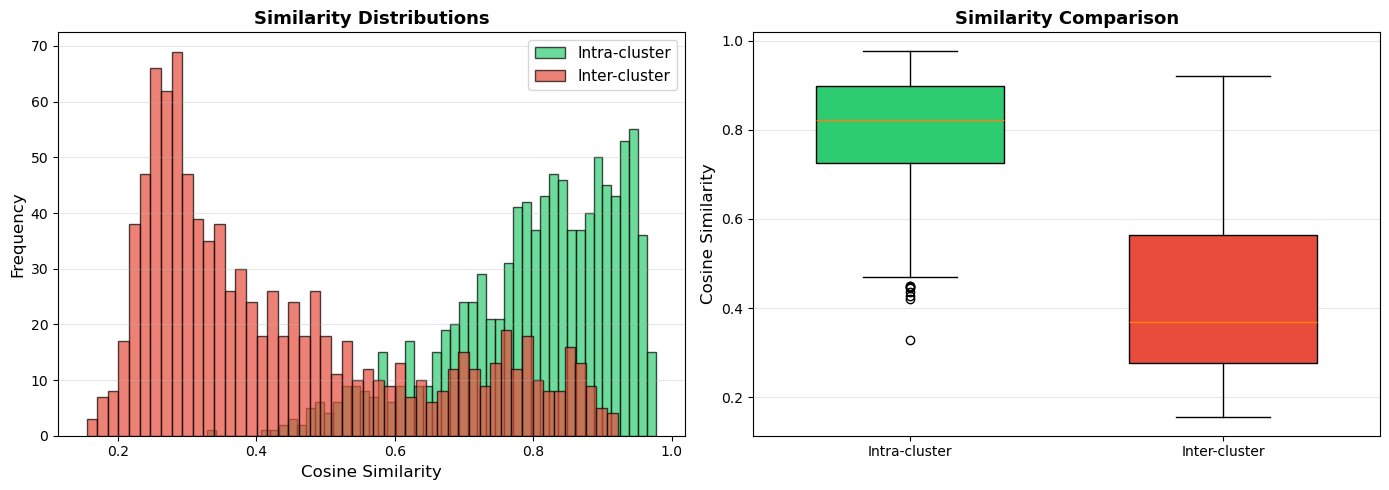

In [20]:
from evaluation import evaluate_intra_cluster_similarity, plot_similarity_distributions

# Evaluate intra vs inter cluster similarity on TEST nodes
intra_inter_results = evaluate_intra_cluster_similarity(
    embeddings_dict=embeddings_dict,
    cluster_df=cluster_df,
    test_node_ids=test_node_ids,  # Only evaluate on test nodes
    n_samples=1000
)

# Visualize the distributions
plot_similarity_distributions(intra_inter_results)


RETRIEVAL EVALUATION (CLUSTER MEMBERSHIP)

Evaluating 1441 test nodes...
K values: [5, 10, 20, 50]


Evaluating retrieval:   0%|          | 0/1441 [00:00<?, ?it/s]


Results:
  K=5:
    Precision@5: 0.9166
    Recall@5: 0.0016
  K=10:
    Precision@10: 0.9129
    Recall@10: 0.0032
  K=20:
    Precision@20: 0.9073
    Recall@20: 0.0065
  K=50:
    Precision@50: 0.8975
    Recall@50: 0.0160


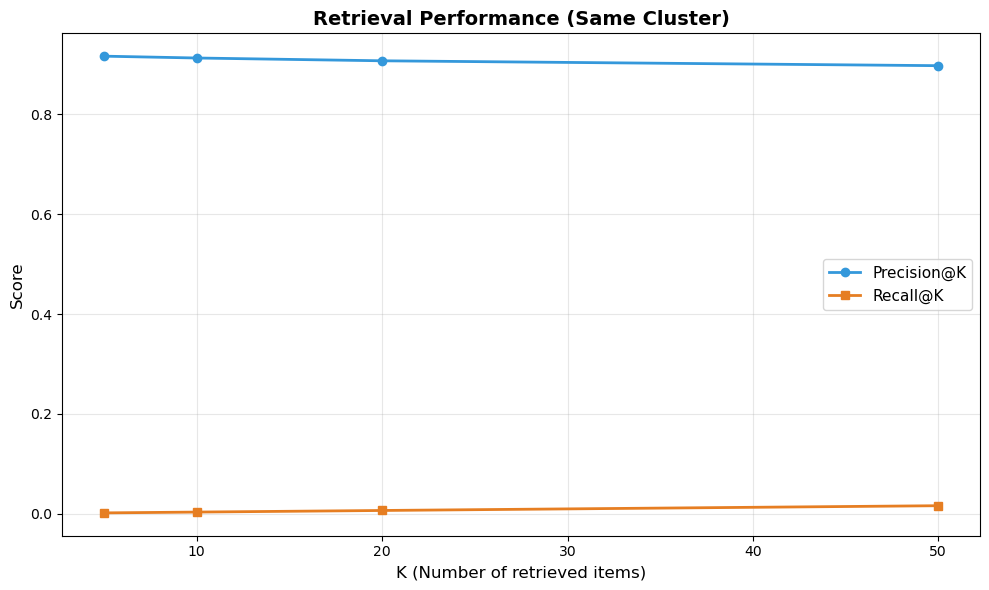

In [21]:
from evaluation import evaluate_retrieval, plot_retrieval_results

# Evaluate retrieval: given a test node, can we retrieve other nodes from same cluster?
retrieval_results = evaluate_retrieval(
    embeddings_dict=embeddings_dict,
    cluster_df=cluster_df,
    test_node_ids=test_node_ids,  # Only test on held-out nodes
    k_values=[5, 10, 20, 50]
)

# Visualize retrieval performance
plot_retrieval_results(retrieval_results)

# Link Prediction Evaluation

This is the primary evaluation metric - same as in hcat experiments!

Found edgelist at /home/rkv4/oc_mini/network/oc_mini_edgelist.csv

NETWORK LINK PREDICTION EVALUATION

Loading edgelist from: /home/rkv4/oc_mini/network/oc_mini_edgelist.csv
Loaded 111873 edges
Network has 14384 unique nodes
Test nodes with embeddings and edges: 1437

Evaluating link prediction with top-k retrieval...
Test nodes: 1437
K values: [5, 10, 20, 50, 100, 500, 1000, 2000]


Evaluating nodes:   0%|          | 0/1437 [00:00<?, ?it/s]


Evaluating link prediction with AUC metrics...
Test nodes: 1437
Negative samples per positive: 10


Sampling edges:   0%|          | 0/1437 [00:00<?, ?it/s]


RESULTS SUMMARY

Top-K Metrics:
  K=5:
    Precision@5: 0.0416
    Precision Normalized@5: 0.0427
    Recall@5: 0.0166
    Hit Rate@5: 0.1768
  K=10:
    Precision@10: 0.0349
    Precision Normalized@10: 0.0415
    Recall@10: 0.0277
    Hit Rate@10: 0.2561
  K=20:
    Precision@20: 0.0273
    Precision Normalized@20: 0.0462
    Recall@20: 0.0410
    Hit Rate@20: 0.3466
  K=50:
    Precision@50: 0.0208
    Precision Normalized@50: 0.0805
    Recall@50: 0.0790
    Hit Rate@50: 0.5157
  K=100:
    Precision@100: 0.0165
    Precision Normalized@100: 0.1228
    Recall@100: 0.1220
    Hit Rate@100: 0.6465
  K=500:
    Precision@500: 0.0092
    Precision Normalized@500: 0.3280
    Recall@500: 0.3279
    Hit Rate@500: 0.8928
  K=1000:
    Precision@1000: 0.0069
    Precision Normalized@1000: 0.4812
    Recall@1000: 0.4812
    Hit Rate@1000: 0.9520
  K=2000:
    Precision@2000: 0.0048
    Precision Normalized@2000: 0.6363
    Recall@2000: 0.6363
    Hit Rate@2000: 0.9840

AUC Metrics:
  AUC-RO

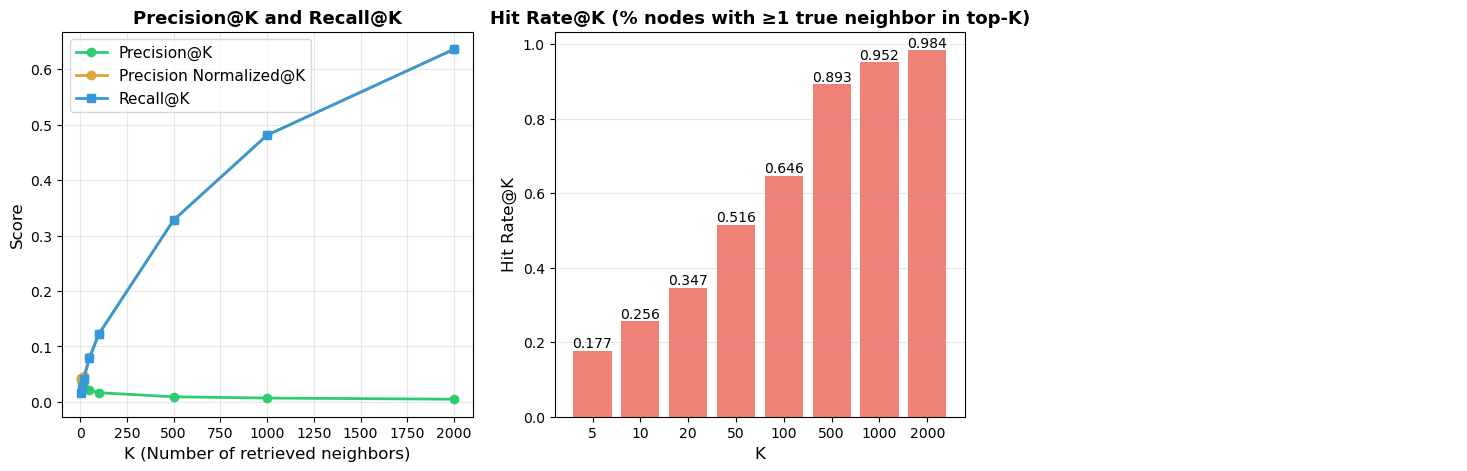

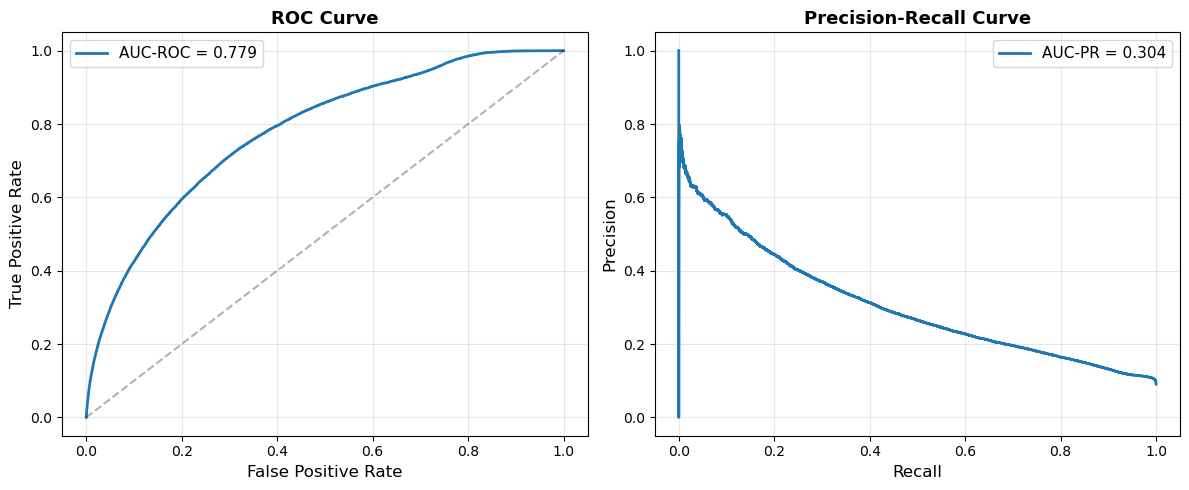

<Figure size 640x480 with 0 Axes>

In [22]:
# Add path to utils for link prediction
sys.path.insert(0, str(BASE_DIR / "cat"/"utils" / "evaluation"))

from link_prediction import evaluate_network_link_prediction, plot_link_prediction_results

# Path to edgelist (if available)
edgelist_path = DATA_DIR / "network" / "oc_mini_edgelist.csv"

# Check if edgelist exists
if edgelist_path.exists():
    print(f"Found edgelist at {edgelist_path}")
    
    # Evaluate link prediction on TEST nodes only
    # K values matching hcat experiments
    link_pred_results = evaluate_network_link_prediction(
        edgelist_path=str(edgelist_path),
        embeddings_dict=embeddings_dict,
        test_nodes=test_node_ids,  # Only evaluate on test nodes
        k_values=[5, 10, 20, 50, 100, 500, 1000, 2000],
        compute_auc=True,
        num_negative_samples=10
    )
    
    # Plot results
    if 'topk' in link_pred_results:
        plot_link_prediction_results(
            link_pred_results['topk'],
            link_pred_results.get('auc')
        )
else:
    print(f"Edgelist not found at {edgelist_path}")
    print("Skipping link prediction evaluation.")

# Baseline Comparison: Evaluate Pre-trained Model (No Fine-tuning)

Let's also compute embeddings using the base model without fine-tuning to see the improvement.

In [23]:
from notebook_utils import compute_embeddings
print("Loading baseline (pre-trained) model...")
baseline_tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print(MODEL_NAME)
baseline_model = AutoModel.from_pretrained(MODEL_NAME).to(device)

print("Computing baseline embeddings...")
baseline_embeddings_dict = compute_embeddings(
    model=baseline_model,
    tokenizer=baseline_tokenizer,
    metadata_df=metadata_df,
    device=device,
    batch_size=32
)

print(f"Baseline embeddings computed: {len(baseline_embeddings_dict)}")

Loading baseline (pre-trained) model...
allenai/scibert_scivocab_uncased
Computing baseline embeddings...
Preparing 14442 documents...


Preparing:   0%|          | 0/14442 [00:00<?, ?it/s]

Computing embeddings:   0%|          | 0/452 [00:00<?, ?it/s]

✓ Computed embeddings for 14442 nodes
Baseline embeddings computed: 14442


In [24]:
print("\n" + "="*80)
print("BASELINE MODEL EVALUATION")
print("="*80)

# Evaluate baseline on same test set - Link prediction only (matching hcat)
if edgelist_path.exists():
    baseline_link_pred = evaluate_network_link_prediction(
        edgelist_path=str(edgelist_path),
        embeddings_dict=baseline_embeddings_dict,
        test_nodes=test_node_ids,
        k_values=[5, 10, 20, 50, 100, 500, 1000, 2000],
        compute_auc=True,
        num_negative_samples=10
    )
else:
    print("Edgelist not found, skipping baseline link prediction")


BASELINE MODEL EVALUATION

NETWORK LINK PREDICTION EVALUATION

Loading edgelist from: /home/rkv4/oc_mini/network/oc_mini_edgelist.csv
Loaded 111873 edges
Network has 14384 unique nodes
Test nodes with embeddings and edges: 1437

Evaluating link prediction with top-k retrieval...
Test nodes: 1437
K values: [5, 10, 20, 50, 100, 500, 1000, 2000]


Evaluating nodes:   0%|          | 0/1437 [00:00<?, ?it/s]


Evaluating link prediction with AUC metrics...
Test nodes: 1437
Negative samples per positive: 10


Sampling edges:   0%|          | 0/1437 [00:00<?, ?it/s]


RESULTS SUMMARY

Top-K Metrics:
  K=5:
    Precision@5: 0.0253
    Precision Normalized@5: 0.0258
    Recall@5: 0.0096
    Hit Rate@5: 0.1086
  K=10:
    Precision@10: 0.0212
    Precision Normalized@10: 0.0252
    Recall@10: 0.0166
    Hit Rate@10: 0.1663
  K=20:
    Precision@20: 0.0175
    Precision Normalized@20: 0.0292
    Recall@20: 0.0255
    Hit Rate@20: 0.2477
  K=50:
    Precision@50: 0.0132
    Precision Normalized@50: 0.0488
    Recall@50: 0.0476
    Hit Rate@50: 0.3807
  K=100:
    Precision@100: 0.0104
    Precision Normalized@100: 0.0756
    Recall@100: 0.0750
    Hit Rate@100: 0.5010
  K=500:
    Precision@500: 0.0061
    Precision Normalized@500: 0.2195
    Recall@500: 0.2193
    Hit Rate@500: 0.7996
  K=1000:
    Precision@1000: 0.0046
    Precision Normalized@1000: 0.3264
    Recall@1000: 0.3264
    Hit Rate@1000: 0.8900
  K=2000:
    Precision@2000: 0.0034
    Precision Normalized@2000: 0.4562
    Recall@2000: 0.4562
    Hit Rate@2000: 0.9513

AUC Metrics:
  AUC-RO

# Comparison: Fine-tuned vs Baseline

Compare the performance of fine-tuned model vs baseline on **link prediction** (matching hcat experiments).

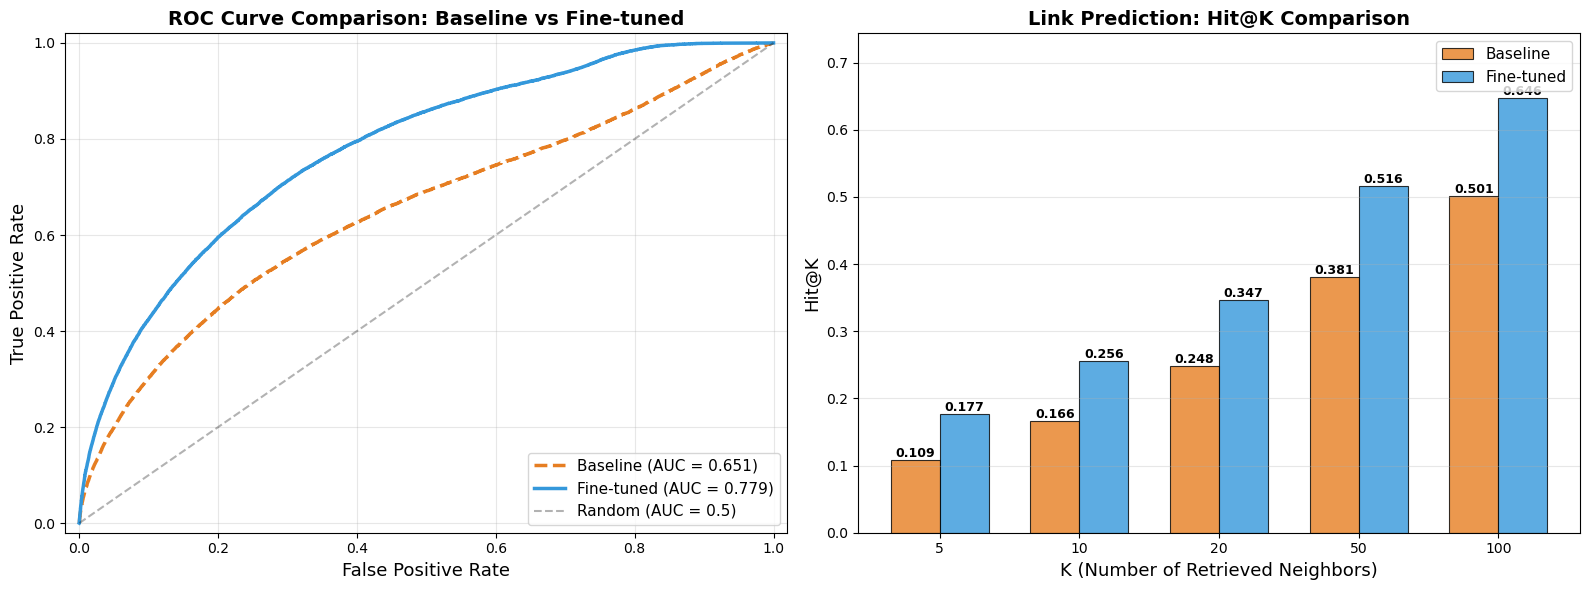


IMPROVEMENT SUMMARY
AUC-ROC Improvement: +19.69%
Average Hit@K Improvement: +38.26%


In [25]:
# Visualization: ROC Curves and Hit@K Comparison
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

if edgelist_path.exists() and 'link_pred_results' in locals() and 'baseline_link_pred' in locals():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # ============================================================================
    # Plot 1: ROC Curves Comparison
    # ============================================================================
    ax = ax1
    
    # Baseline ROC (red/orange)
    if 'auc' in baseline_link_pred and baseline_link_pred['auc']:
        fpr_bl, tpr_bl, _ = roc_curve(
            baseline_link_pred['auc']['y_true'], 
            baseline_link_pred['auc']['y_scores']
        )
        ax.plot(fpr_bl, tpr_bl, linewidth=2.5, 
                label=f"Baseline (AUC = {baseline_link_pred['auc']['auc_roc']:.3f})",
                color='#e67e22', linestyle='--')  # Orange
    
    # Fine-tuned ROC (blue)
    if 'auc' in link_pred_results and link_pred_results['auc']:
        fpr_ft, tpr_ft, _ = roc_curve(
            link_pred_results['auc']['y_true'], 
            link_pred_results['auc']['y_scores']
        )
        ax.plot(fpr_ft, tpr_ft, linewidth=2.5, 
                label=f"Fine-tuned (AUC = {link_pred_results['auc']['auc_roc']:.3f})",
                color='#3498db')  # Blue
    
    # Diagonal reference line
    ax.plot([0, 1], [0, 1], 'k--', alpha=0.3, linewidth=1.5, label='Random (AUC = 0.5)')
    
    ax.set_xlabel('False Positive Rate', fontsize=13)
    ax.set_ylabel('True Positive Rate', fontsize=13)
    ax.set_title('ROC Curve Comparison: Baseline vs Fine-tuned', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11, loc='lower right')
    ax.grid(True, alpha=0.3)
    ax.set_xlim([-0.02, 1.02])
    ax.set_ylim([-0.02, 1.02])
    
    # ============================================================================
    # Plot 2: Hit@K Bar Chart Comparison
    # ============================================================================
    ax = ax2
    
    # Use only K values [5, 10, 20, 50, 100]
    k_display = [5, 10, 20, 50, 100]
    baseline_hits = [baseline_link_pred['topk']['summary'][k]['hit_rate@k'] for k in k_display]
    finetuned_hits = [link_pred_results['topk']['summary'][k]['hit_rate@k'] for k in k_display]
    
    x = np.arange(len(k_display))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, baseline_hits, width, 
                   label='Baseline', color='#e67e22', alpha=0.8, edgecolor='black', linewidth=0.8)  # Orange
    bars2 = ax.bar(x + width/2, finetuned_hits, width, 
                   label='Fine-tuned', color='#3498db', alpha=0.8, edgecolor='black', linewidth=0.8)  # Blue
    
    ax.set_xlabel('K (Number of Retrieved Neighbors)', fontsize=13)
    ax.set_ylabel('Hit@K', fontsize=13)
    ax.set_title('Link Prediction: Hit@K Comparison', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(k_display)
    ax.legend(fontsize=11, loc='upper right')
    ax.grid(True, axis='y', alpha=0.3)
    ax.set_ylim([0, min(1.0, max(max(baseline_hits), max(finetuned_hits)) * 1.15)])
    
    # Add value labels on bars
    def add_value_labels(bars):
        for bar in bars:
            height = bar.get_height()
            if height > 0.001:  # Only show label if bar is visible
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.3f}',
                       ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    add_value_labels(bars1)
    add_value_labels(bars2)
    
    plt.tight_layout()
    plt.show()
    
    # Print improvement summary
    print("\n" + "="*80)
    print("IMPROVEMENT SUMMARY")
    print("="*80)
    if 'auc' in link_pred_results and 'auc' in baseline_link_pred:
        auc_improvement = ((link_pred_results['auc']['auc_roc'] - baseline_link_pred['auc']['auc_roc']) 
                          / baseline_link_pred['auc']['auc_roc'] * 100)
        print(f"AUC-ROC Improvement: {auc_improvement:+.2f}%")
    
    avg_baseline_hit = np.mean(baseline_hits)
    avg_finetuned_hit = np.mean(finetuned_hits)
    avg_improvement = ((avg_finetuned_hit - avg_baseline_hit) / avg_baseline_hit * 100)
    print(f"Average Hit@K Improvement: {avg_improvement:+.2f}%")
    print("="*80)
else:
    print("Link prediction results not available for visualization")

In [26]:
import pandas as pd

# Create comparison table for link prediction (matching hcat experiments)
if edgelist_path.exists() and 'link_pred_results' in locals() and 'baseline_link_pred' in locals():
    
    comparison_data = {
        'K': [],
        'Baseline Precision@K': [],
        'Fine-tuned Precision@K': [],
        'Improvement': []
    }

    k_values = link_pred_results['topk']['k_values']
    
    for k in k_values:
        bl_prec = baseline_link_pred['topk']['summary'][k]['precision@k']
        ft_prec = link_pred_results['topk']['summary'][k]['precision@k']
        improvement = ((ft_prec - bl_prec) / bl_prec) * 100 if bl_prec != 0 else 0
        
        comparison_data['K'].append(k)
        comparison_data['Baseline Precision@K'].append(f"{bl_prec:.4f}")
        comparison_data['Fine-tuned Precision@K'].append(f"{ft_prec:.4f}")
        comparison_data['Improvement'].append(f"{improvement:+.2f}%")

    comparison_df = pd.DataFrame(comparison_data)

    print("\n" + "="*80)
    print("PERFORMANCE COMPARISON: BASELINE VS FINE-TUNED (LINK PREDICTION)")
    print("="*80)
    print(comparison_df.to_string(index=False))
    
    # AUC comparison
    if 'auc' in link_pred_results and 'auc' in baseline_link_pred:
        bl_auc = baseline_link_pred['auc']['auc_roc']
        ft_auc = link_pred_results['auc']['auc_roc']
        auc_improvement = ((ft_auc - bl_auc) / bl_auc) * 100
        
        print(f"\nAUC-ROC:")
        print(f"  Baseline: {bl_auc:.4f}")
        print(f"  Fine-tuned: {ft_auc:.4f}")
        print(f"  Improvement: {auc_improvement:+.2f}%")
    
    print("="*80)
else:
    print("Link prediction results not available for comparison")


PERFORMANCE COMPARISON: BASELINE VS FINE-TUNED (LINK PREDICTION)
   K Baseline Precision@K Fine-tuned Precision@K Improvement
   5               0.0253                 0.0416     +64.29%
  10               0.0212                 0.0349     +64.59%
  20               0.0175                 0.0273     +56.06%
  50               0.0132                 0.0208     +58.52%
 100               0.0104                 0.0165     +58.45%
 500               0.0061                 0.0092     +50.65%
1000               0.0046                 0.0069     +49.17%
2000               0.0034                 0.0048     +41.01%

AUC-ROC:
  Baseline: 0.6510
  Fine-tuned: 0.7792
  Improvement: +19.69%


In [27]:
# Save results to JSON
import json
from datetime import datetime
import numpy as np

def to_python(obj):
    if isinstance(obj, (np.floating, np.float32, np.float64)):
        return float(obj)
    if isinstance(obj, (np.integer, np.int32, np.int64)):
        return int(obj)
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    return str(obj)  # fallback


if 'link_pred_results' in locals():
    results_data = {
        'timestamp': datetime.now().isoformat(),
        'model_name': MODEL_NAME,
        'hyperparameters': {
            'epochs': EPOCHS,
            'batch_size': BATCH_SIZE,
            'learning_rate': LEARNING_RATE,
            'margin': MARGIN,
            'samples_per_cluster': SAMPLES_PER_CLUSTER
        },
        'split': {
            'train_nodes': len(train_node_ids),
            'test_nodes': len(test_node_ids),
            'test_ratio': len(test_node_ids) / (len(train_node_ids) + len(test_node_ids))
        },
        'fine_tuned': {
            'link_prediction': {
                'topk': link_pred_results['topk']['summary'],
                'auc': link_pred_results.get('auc')
            }
        }
    }
    
    if 'baseline_link_pred' in locals():
        results_data['baseline'] = {
            'link_prediction': {
                'topk': baseline_link_pred['topk']['summary'],
                'auc': baseline_link_pred.get('auc')
            }
        }

    # Create results directory
    results_dir = Path.cwd() / "results"
    results_dir.mkdir(exist_ok=True)

    results_file = results_dir / f"disjoint_results_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
    with open(results_file, 'w') as f:
        json.dump(results_data, f, indent=2, default=to_python)

    print(f"\nResults saved to: {results_file}")
else:
    print("Link prediction results not available to save")


Results saved to: /home/rkv4/cat/dcat/experiments/results/disjoint_results_20251201_220534.json
